In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [2]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.308725,0.235825,0.566757,0.982782,0.707526,1.000000,0.410887,0.671068,1.000000,0.438527
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.000000,0.861588,0.000000,0.640911,0.020238,0.220356,0.632252,0.000000,0.488578
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.491401,0.279122,0.555258,0.000000,0.392175,0.000000,0.116289,0.000000,0.260194,0.531400
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.604918,0.598850,0.621841,0.000000,0.519941,0.000000,0.342185,0.416527,0.000000,0.545708
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.470835,0.670696,0.555250,0.000000,0.390923,0.000000,0.498504,0.449224,0.000000,0.689242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.669319,0.770253,0.702931,0.000000,0.451846,0.000000,0.319644,0.549587,0.000000,0.935108
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.747236,0.742399,0.730485,0.000000,0.680460,0.000000,0.280413,0.529434,0.000000,0.606330
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.422981,0.769213,0.625325,0.000000,0.374319,0.000000,0.396084,0.590976,0.238307,0.753111


In [3]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.775985,0.973492,0.472825,0.0,0.269797,0.0,0.539781,0.290165,0.000000,0.722611
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.582213,0.531660,0.540145,0.0,0.322049,0.0,0.303573,0.133159,0.000000,0.537012
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.907365,0.736128,-0.336653,0.0,-0.069528,0.0,0.176989,0.766373,0.000000,1.094845
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.648501,0.789699,0.836996,0.0,0.285660,0.0,0.320280,0.488913,0.000000,0.674738
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.493294,0.566990,0.807264,0.0,0.471971,0.0,0.462733,0.508932,0.000000,0.693707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.550182,0.719685,0.701615,0.0,0.225656,0.0,0.295914,0.701896,0.000000,0.709542
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.819116,0.689739,0.213157,0.0,0.969447,0.0,0.134090,0.710444,0.000000,0.846294
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.417027,0.734039,0.683655,0.0,0.369566,0.0,0.405814,0.575430,0.000000,0.653918


In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
# compound_model = keras.models.load_model('cd_clf')

In [7]:
# compound_model.summary()

## SHAP evaluation

In [8]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [9]:
import objects

In [10]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=True)

getting explainerinitialising explainer
link.f
link.f
link.f
link.f


## Calculate SHAP values

In [11]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [12]:
# shap_values

## Save SHAP values

In [13]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [126]:


with open("../data/models/shap/new_fd_all_400", "rb") as fp:   # Unpickling
# with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [127]:
shap_values = shap_values[0]


In [110]:
# for i in range(3):
#     shap_values[i] /= 100

In [128]:
shap_values

[array([[ -5.70689155,  -0.39506205,  12.00137403, ..., -11.004111  ,
           4.28796348,   4.39557852],
        [  0.        ,   1.92880037,   0.        , ...,  -7.30004053,
           6.13391577,   0.        ],
        [-82.98517662,  43.34163091,   2.52986131, ..., -30.16699173,
           0.        , -27.93647385],
        ...,
        [ -3.85419159,  -5.85167892,   5.72882966, ...,  -5.85192457,
           0.64837961,   0.        ],
        [ -2.44850168,  33.59363253, -19.90611052, ...,  -2.31882258,
         -38.57529636,  -3.71792596],
        [  0.        ,   3.57590782,   1.81978695, ...,   4.31856181,
           6.73597274,   1.27532674]]),
 array([[-22.12823303, -95.01366678, 112.20667468, ..., 191.99600946,
         -66.29740394,  88.28124835],
        [-11.43931563,   0.        ,  10.66244696, ...,   0.        ,
          -2.1221713 ,  24.83172071],
        [-87.59067868,   0.        ,  35.01728445, ..., -38.45457273,
          73.60651548,   0.        ],
        ...,


In [129]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [130]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
46_CD_deep_ulcer,0.438089,0.482152,0.410237,0.378247,0.438691,0.705762,0.339106,0.559666,0.878088,0.228893,...,0.964177,0.715558,0.716592,0.0,0.684122,0.0,0.136883,0.624877,0.0,0.877226


In [131]:
gmm_model_get_prediction_ae(patient)[0]

array([9.19121317e-23, 6.06741518e-04, 9.99393258e-01])

In [132]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

#### Control

In [133]:
import shap

In [134]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [135]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [136]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [137]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

_explanation.Explanation

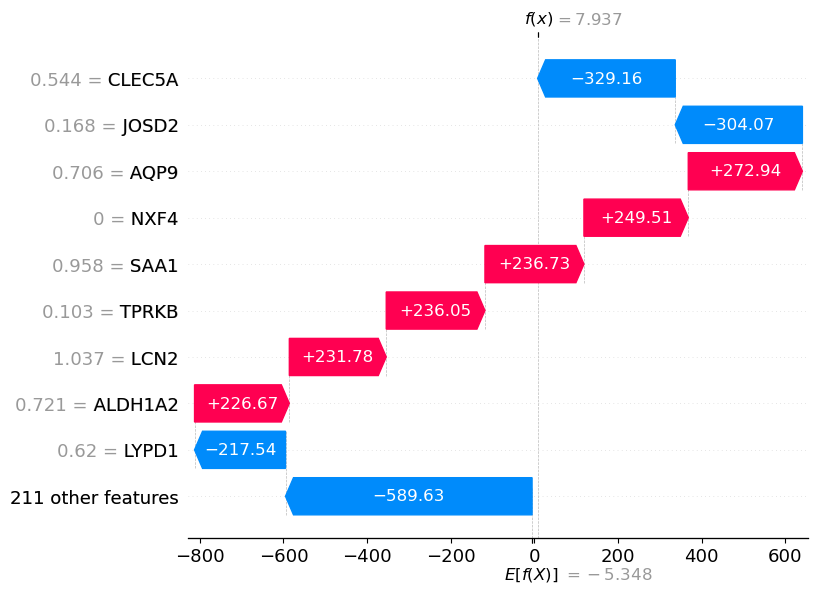

In [138]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [122]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [123]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [124]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

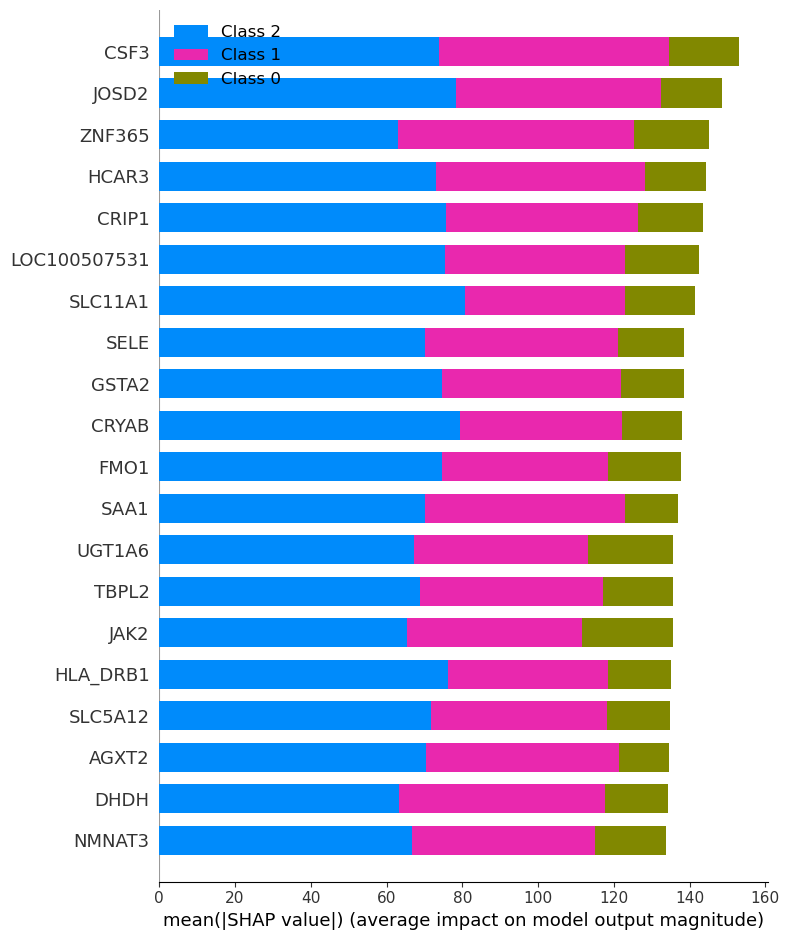

In [139]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


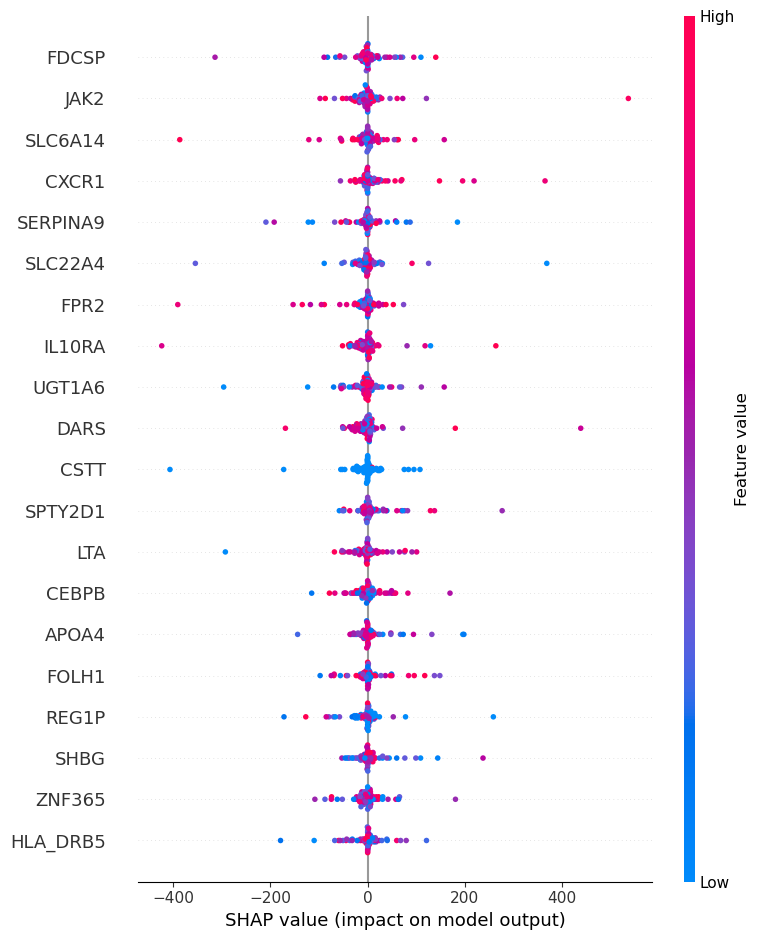

In [140]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

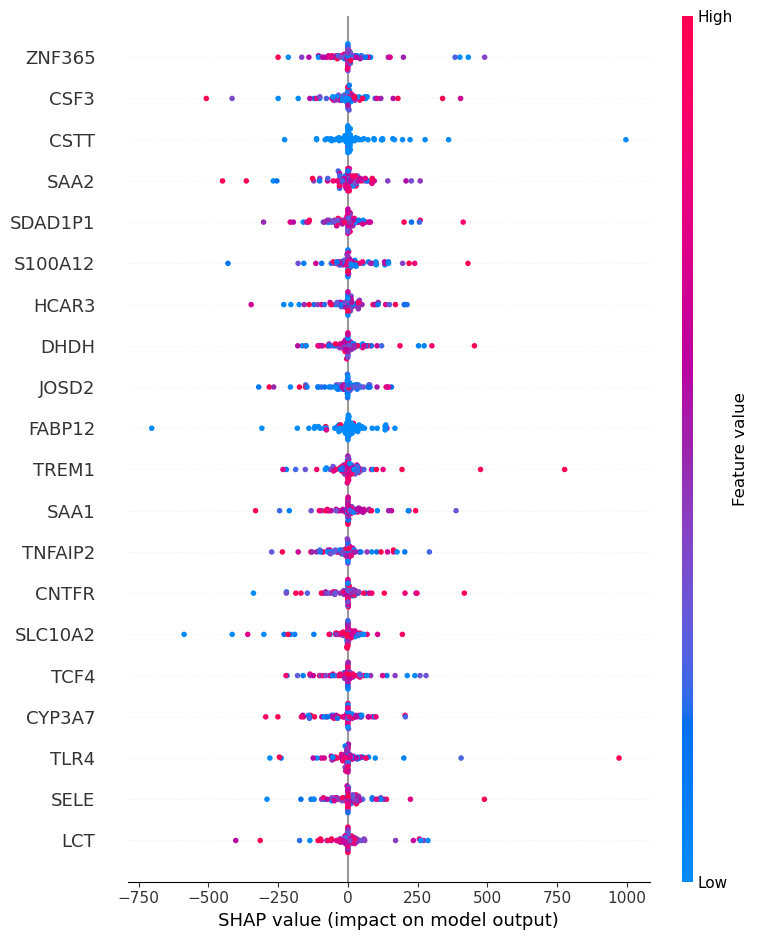

In [141]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

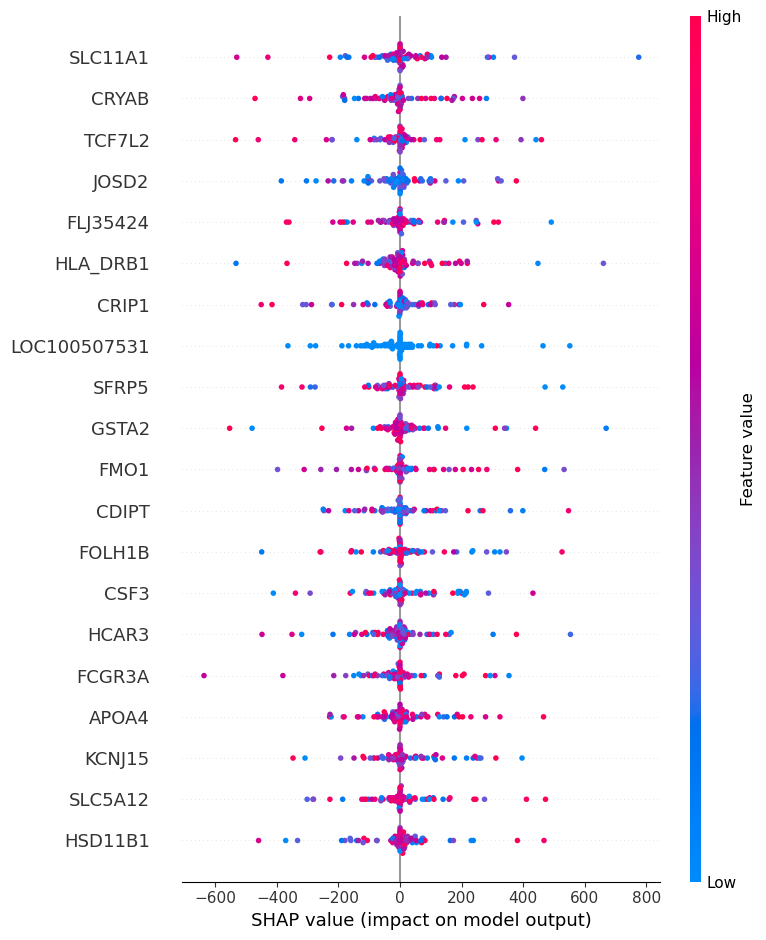

In [142]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

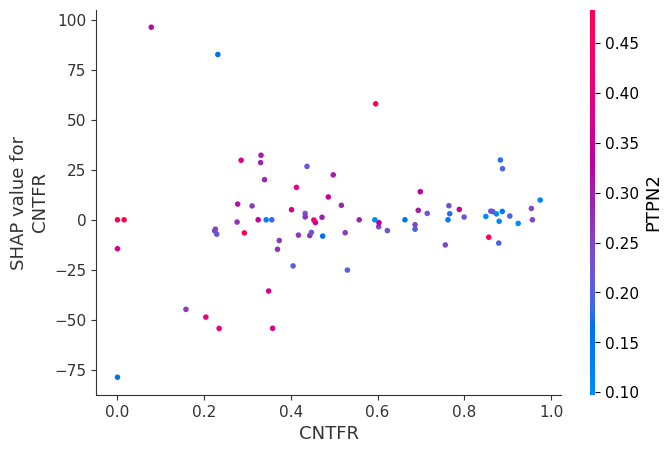

In [143]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

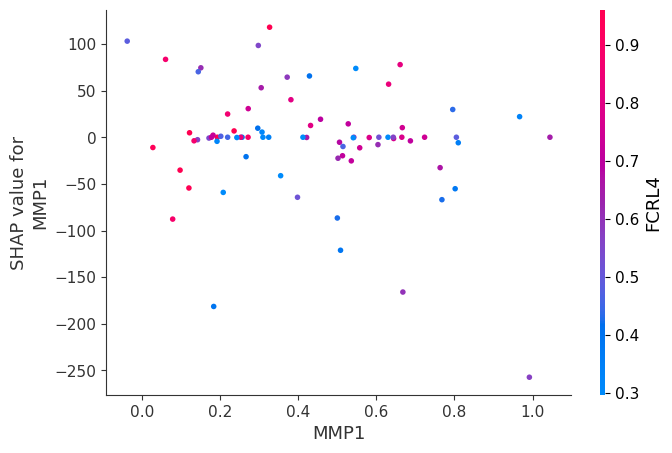

In [144]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

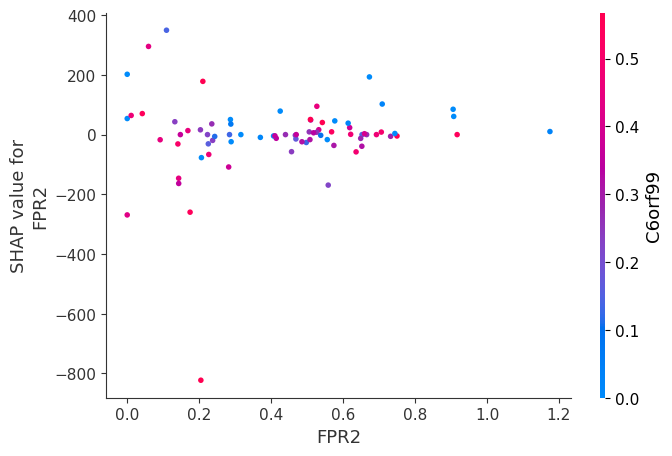

In [145]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [37]:
disease_labels_test.shape

(78,)

In [38]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [39]:
clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
No/low signal found from feature 13 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 78%|██████████████████████████████████████████████████████████████▌                 | 172/220 [01:09<00:19,  2.50it/s]No/low signal found from feature 171 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 172 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 98%|██████████████████████████████████████████████████████████████████████████████▌ | 216/220 [01:25<00:01,  3.30it/s]No/low signal found from feature 215 (this is typically cause

In [40]:
# clustering

In [41]:
# clustering.shape

In [42]:
row = 77
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [43]:
type(exp)

shap._explanation.Explanation

In [44]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [45]:

# with open("../clust", "rb") as fp:   # Unpickling
#     clustering = pickle.load(fp)

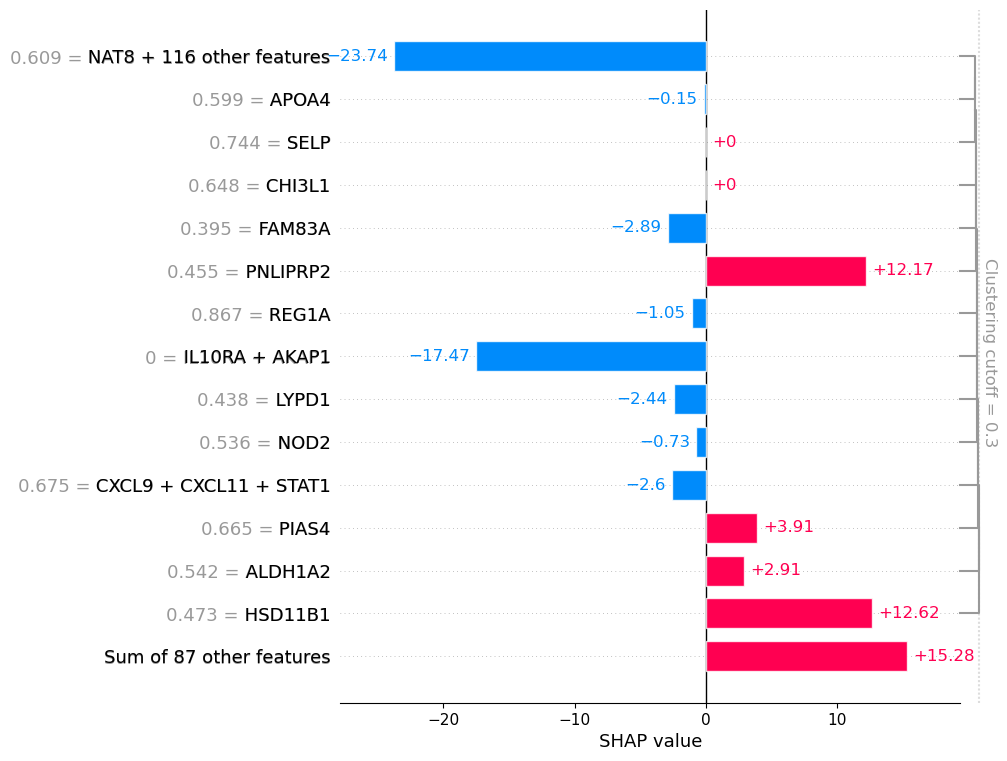

In [46]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [48]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,181.888910,1.914024,176.950805,144.321532,0.000000,273.772127,-185.814239,94.092865,-189.449460,-2.508185,...,124.445448,-645.367477,0.000000,464.565373,0.000000,241.088596,-124.564137,-163.590349,-322.584965,0.000000
167_CD_deep_ulcer,-37.649453,19.217504,-72.835227,-254.840862,-61.730168,-15.589437,-13.494166,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-61.216412,0.000000,-64.321642,8.641959,-21.801036,-34.932302,-52.105806
196_CD_deep_ulcer,19.426408,0.000000,18.523802,80.274120,-155.775380,107.292892,-139.082771,161.474997,22.224653,140.544483,...,0.000000,0.000000,-61.098793,-91.159306,1.527359,53.121020,18.680391,-152.873308,0.000000,-110.150081
23_CD_deep_ulcer,-106.843172,-117.380258,-2.545532,3.831497,-89.081406,58.302064,37.707213,0.000000,-18.175238,0.000000,...,-36.843057,0.000000,-47.810232,-127.758060,0.000000,47.162571,20.831836,54.126966,-31.050839,48.061308
93_CD_deep_ulcer,0.000000,6.690726,-6.070102,8.470295,-9.685870,0.564730,3.532034,8.289445,-8.082136,-1.501797,...,0.000000,-8.924754,0.000000,0.000000,11.736700,-11.776939,1.328474,0.000000,-4.655718,0.000000
229_CD_deep_ulcer,-22.335321,7.879571,11.546794,2.407135,-35.595690,-29.799112,0.000000,-11.155027,-28.545809,-18.625722,...,-1.392658,-14.670382,14.374682,-24.463994,29.424843,-1.089611,-5.421152,0.000000,-16.267767,-16.523588
46_CD_deep_ulcer,37.553746,192.331688,0.000000,34.343399,-190.952106,272.944804,106.889690,11.553501,0.000000,-24.040982,...,-1.664652,11.719961,-89.824412,0.000000,0.000000,249.510789,-32.788700,-0.724000,136.886700,29.001965
176_CD_deep_ulcer,16.176659,8.941275,20.906431,-13.005244,5.988478,18.942496,25.561843,0.000000,-9.461055,-9.374612,...,14.438234,-34.084343,0.000000,16.147432,45.077480,2.962031,0.000000,-7.568801,0.000000,-7.605372
49_CD_deep_ulcer,-123.954208,21.809467,152.506990,223.260364,0.000000,-15.828794,4.326026,-30.715958,-167.212736,380.945229,...,-168.207759,274.497452,-8.216509,551.690071,0.000000,-61.181642,0.000000,255.975121,0.000000,-454.496281


### Example: CD deep ulcer patients

In [49]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

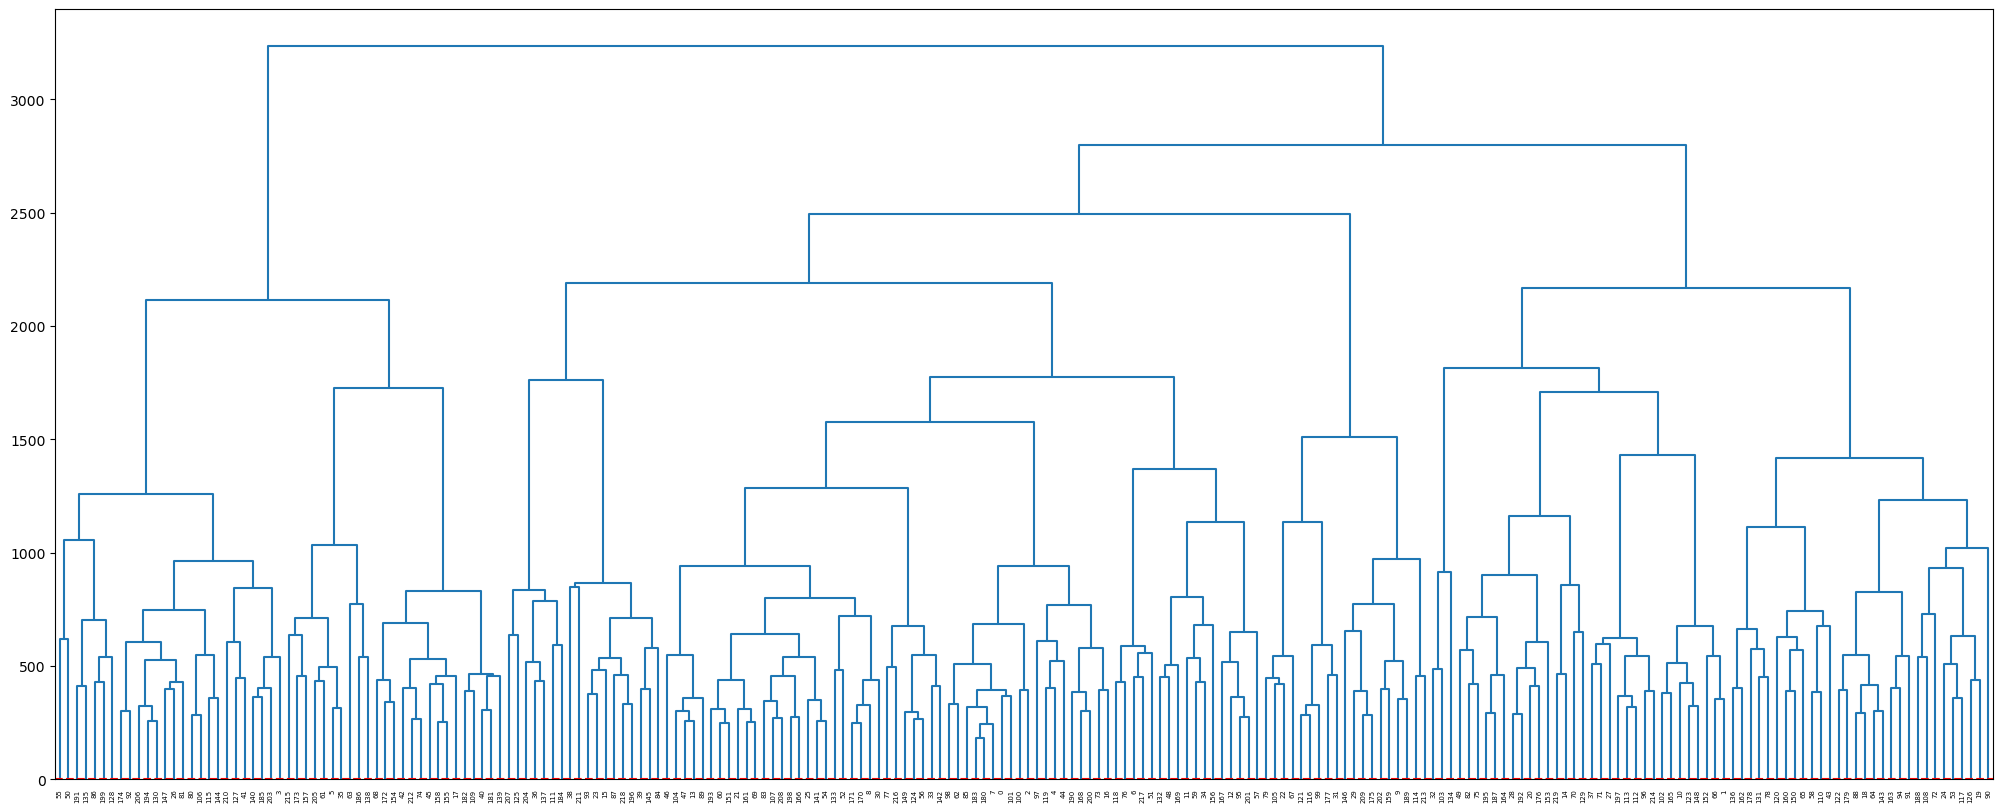

In [50]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = .7, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [51]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([ 55,  50, 191, 135,  86, 199, 128, 174,  92, 206, 194, 130, 147,
        26,  81,  80, 106, 115, 144, 210, 127,  41, 140, 185, 203,   3,
       215, 173, 157, 205,  61,   5,  35,  63, 186, 138,  68, 172, 154,
        42, 212,  74,  45, 158, 155,  17, 182, 109,  40, 181, 139, 207,
       125, 204,  36, 137, 111, 184,  38, 211,  93,  23,  15,  87, 218,
       196,  39, 145,  84,  46, 104,  47,  13,  89, 193,  60, 151,  21,
       161,  69,  83, 107, 208, 198, 166,  25, 141,  54, 133,  52, 171,
       170,   8,  30,  77, 216, 149, 124,  56,  33, 142,  98,  62,  85,
       183, 180,   7,   0, 101, 100,   2,  97, 119,   4,  44, 190, 168,
       200,  73,  16, 118,  76,   6, 217,  51, 132,  48, 169,  11,  59,
        34, 156, 167,  12,  95, 201,  57,  79, 105,  22,  67, 121, 116,
        99, 177,  31, 146,  29, 209, 175, 202, 159,   9, 189, 114, 213,
        32, 103, 134,  49,  82,  75, 195, 187, 164,  28, 192,  20, 176,
       153, 219,  14,  70, 129,  37,  71,  27, 197, 113, 112,  9

In [52]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'HDLBP', 'PIAS4', 'ADH1B', 'LOC100507531', 'FAM83A', 'NXF4', 'RNF125',
       'DARS', 'DNAI1', 'MBTPS1'],
      dtype='object', length=220)

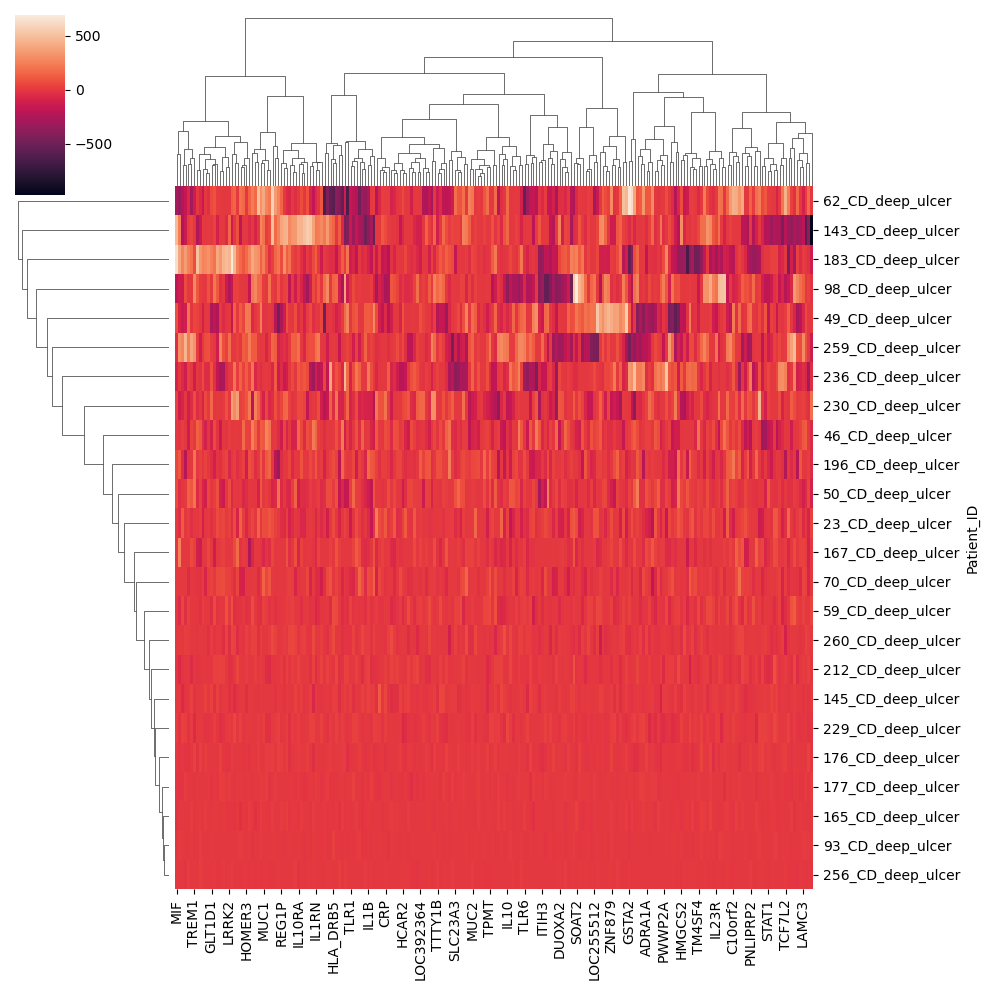

In [53]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [54]:
gene_cluster_cd_deep

array([[1.83000000e+02, 1.80000000e+02, 1.82112018e+02, 2.00000000e+00],
       [2.20000000e+02, 7.00000000e+00, 2.41251266e+02, 3.00000000e+00],
       [6.00000000e+01, 1.51000000e+02, 2.45745067e+02, 2.00000000e+00],
       [1.71000000e+02, 1.70000000e+02, 2.47780999e+02, 2.00000000e+00],
       [1.61000000e+02, 6.90000000e+01, 2.50712273e+02, 2.00000000e+00],
       [1.58000000e+02, 1.55000000e+02, 2.53522120e+02, 2.00000000e+00],
       [1.94000000e+02, 1.30000000e+02, 2.55001132e+02, 2.00000000e+00],
       [1.41000000e+02, 5.40000000e+01, 2.57390924e+02, 2.00000000e+00],
       [4.70000000e+01, 1.30000000e+01, 2.58156677e+02, 2.00000000e+00],
       [1.24000000e+02, 5.60000000e+01, 2.63811551e+02, 2.00000000e+00],
       [2.12000000e+02, 7.40000000e+01, 2.64320724e+02, 2.00000000e+00],
       [1.07000000e+02, 2.08000000e+02, 2.67827457e+02, 2.00000000e+00],
       [9.50000000e+01, 2.01000000e+02, 2.72664919e+02, 2.00000000e+00],
       [1.98000000e+02, 1.66000000e+02, 2.73015275e

In [55]:
cluster_labels = fcluster(gene_cluster_cd_deep, .7, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(220,)

In [56]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([ 55,  50, 191, 135,  86, 199, 128, 174,  92, 194, 130, 206, 147,
         26,  81,  80, 106, 115, 144, 127,  41, 210, 140, 185, 203,   3,
        173, 157, 215, 205,  61,   5,  35, 186, 138,  63, 172, 154,  68,
        212,  74,  42, 158, 155,  45,  17, 182, 109,  40, 181, 139, 207,
        125,  36, 137, 204, 111, 184,  38, 211,  93,  23,  15, 218, 196,
         87,  39, 145,  84,  47,  13, 104,  89,  46,  60, 151, 193, 161,
         69,  21, 107, 208,  83, 198, 166, 141,  54,  25, 133,  52, 171,
        170,   8,  30,  77, 216, 124,  56, 149,  33, 142,  98,  62, 183,
        180,   7,  85,   0, 101, 100,   2, 119,   4,  44,  97, 168, 200,
        190,  73,  16, 118,  76,   6, 217,  51, 132,  48, 169,  59,  34,
         11, 156,  95, 201,  12, 167,  57, 105,  22,  79,  67, 121, 116,
         99, 177,  31, 209, 175,  29, 146, 202, 159,   9, 189, 114, 213,
         32, 103, 134,  82,  75,  49, 195, 187, 164,  28, 192,  20, 176,
        153, 219,  14,  70, 129,  37,  71,  27, 113

In [57]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [58]:
cluster_labels

array([108, 189, 111,  26, 113,  32, 123, 106,  93, 153, 187, 131, 135,
        71, 172,  63, 120,  46, 206, 219, 168,  80, 139,  62, 217,  88,
        14, 177, 166, 149,  94, 146, 157, 100, 130,  33,  54, 175,  59,
        67,  49,  21,  42, 202, 114,  45,  74,  70, 127, 162,   2, 125,
        90, 215,  87,   1,  98, 137, 200, 129,  75,  31, 103,  36, 207,
       198, 188, 141,  39,  79, 173, 176, 214, 119,  41, 161, 122,  95,
       194, 140,  16,  15, 160,  83,  69, 107,   5,  66, 205,  73, 220,
       211,   9,  61, 210, 133, 181, 115, 102, 144, 110, 109, 183, 158,
        72, 138,  17,  81, 213,  48, 201,  57, 179, 178, 155,  18, 143,
       216, 121, 112, 199, 142, 203, 185,  97,  53, 218,  20,   7, 174,
        11, 193, 126,  89, 159,   4, 191,  55,  35,  51,  23,  86, 101,
       208,  19,  68, 150,  13, 186,  99, 197,  76, 190, 170,  38,  44,
       132,  28,  43, 152, 196,  78, 192, 209, 165, 184,  85, 136, 116,
       128,  92,  91,  37,  27,   8, 148, 169, 145, 195, 204, 10

In [59]:
df_cd_deep.columns.get_loc("OSM")

63

In [60]:
np.where(cluster_labels == 2) #osm

(array([50], dtype=int64),)

In [61]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,24.0,-1.850587,64.646806,-123.954208,-26.163854,1.021452,21.617465,181.888910,AADAC,108
APOA1,24.0,17.274679,121.360845,-117.380258,-7.795198,0.000000,8.144997,519.189102,APOA1,189
APOA4,24.0,7.012683,103.693887,-223.649002,-24.725949,-0.074660,35.660402,230.132005,APOA4,111
APOB,24.0,30.917849,120.294255,-254.840862,-1.710881,2.901246,45.826079,264.073569,APOB,26
APOC3,24.0,-19.091729,87.147682,-190.952106,-58.948820,-4.842935,6.893896,237.213437,APOC3,113
...,...,...,...,...,...,...,...,...,...,...
NXF4,24.0,53.745388,128.739917,-208.777402,-2.490826,3.385403,81.946194,404.490407,NXF4,29
RNF125,24.0,-21.439145,111.423724,-462.043092,-6.822902,3.026164,12.363950,130.795868,RNF125,96
DARS,24.0,-24.647712,108.210957,-256.784769,-47.673493,-0.917686,11.041897,255.975121,DARS,124
DNAI1,24.0,-27.798126,100.789435,-327.706085,-32.681253,-7.225089,0.000000,136.886700,DNAI1,64


In [62]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,-1.850587,108,AADAC
APOA1,17.274679,189,APOA1
APOA4,7.012683,111,APOA4
APOB,30.917849,26,APOB
APOC3,-19.091729,113,APOC3
...,...,...,...
NXF4,53.745388,29,NXF4
RNF125,-21.439145,96,RNF125
DARS,-24.647712,124,DARS
DNAI1,-27.798126,64,DNAI1


In [63]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,-1.850587,108,AADAC
APOA1,17.274679,189,APOA1
APOA4,7.012683,111,APOA4
APOB,30.917849,26,APOB
APOC3,-19.091729,113,APOC3
...,...,...,...
NXF4,53.745388,29,NXF4
RNF125,-21.439145,96,RNF125
DARS,-24.647712,124,DARS
DNAI1,-27.798126,64,DNAI1


In [64]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [65]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [66]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: abs(mean_vals[i]) for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [67]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,30.036764,1,[MIF]
2,17.403595,1,[KCNJ15]
3,-11.579912,1,[CDIPT]
4,2.568779,1,[AGXT2]
5,21.472364,1,[SLC22A4]
...,...,...,...
216,3.906276,1,[LAMC3]
217,-19.410944,1,[FOXD1]
218,-12.926837,1,[DUOX2]


In [68]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,30.036764,1,[MIF],MIF
2,17.403595,1,[KCNJ15],KCNJ15
3,-11.579912,1,[CDIPT],CDIPT
4,2.568779,1,[AGXT2],AGXT2
5,21.472364,1,[SLC22A4],SLC22A4
...,...,...,...,...
216,3.906276,1,[LAMC3],LAMC3
217,-19.410944,1,[FOXD1],FOXD1
218,-12.926837,1,[DUOX2],DUOX2


In [69]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [70]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,30.036764,1,[MIF],MIF
2,17.403595,1,[KCNJ15],KCNJ15
3,-11.579912,1,[CDIPT],CDIPT
4,2.568779,1,[AGXT2],AGXT2
5,21.472364,1,[SLC22A4],SLC22A4
...,...,...,...,...
215,3.906276,1,[LAMC3],LAMC3
216,-19.410944,1,[FOXD1],FOXD1
218,-12.926837,1,[DUOX2],DUOX2
219,-29.895949,1,[FCGR1B],FCGR1B


In [71]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,30.036764,1,[MIF],MIF
2,17.403595,1,[KCNJ15],KCNJ15
3,-11.579912,1,[CDIPT],CDIPT
4,2.568779,1,[AGXT2],AGXT2
5,21.472364,1,[SLC22A4],SLC22A4
...,...,...,...,...
216,-19.410944,1,[FOXD1],FOXD1
217,-11.243543,1,[LTA],LTA
218,-12.926837,1,[DUOX2],DUOX2
219,-29.895949,1,[FCGR1B],FCGR1B


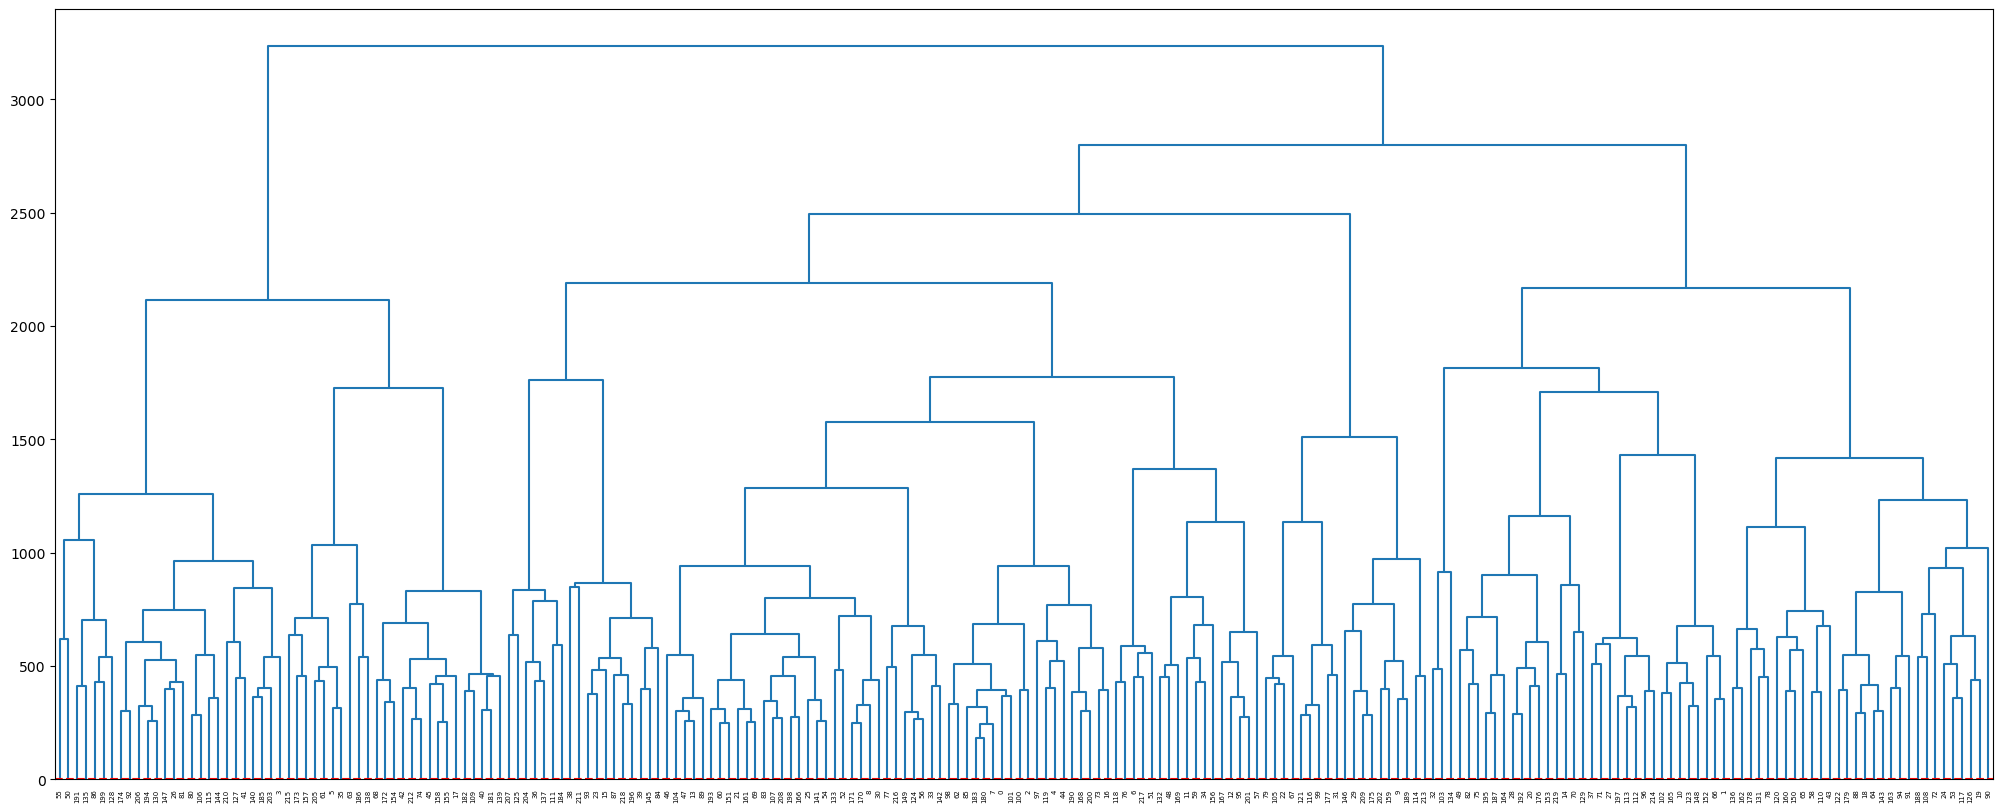

In [72]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = 0.7)
plt.axhline(y=.7, c='r', linestyle='--')

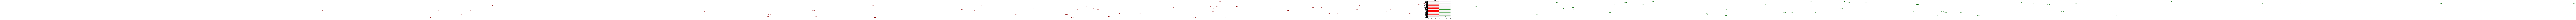

In [73]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [74]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [75]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

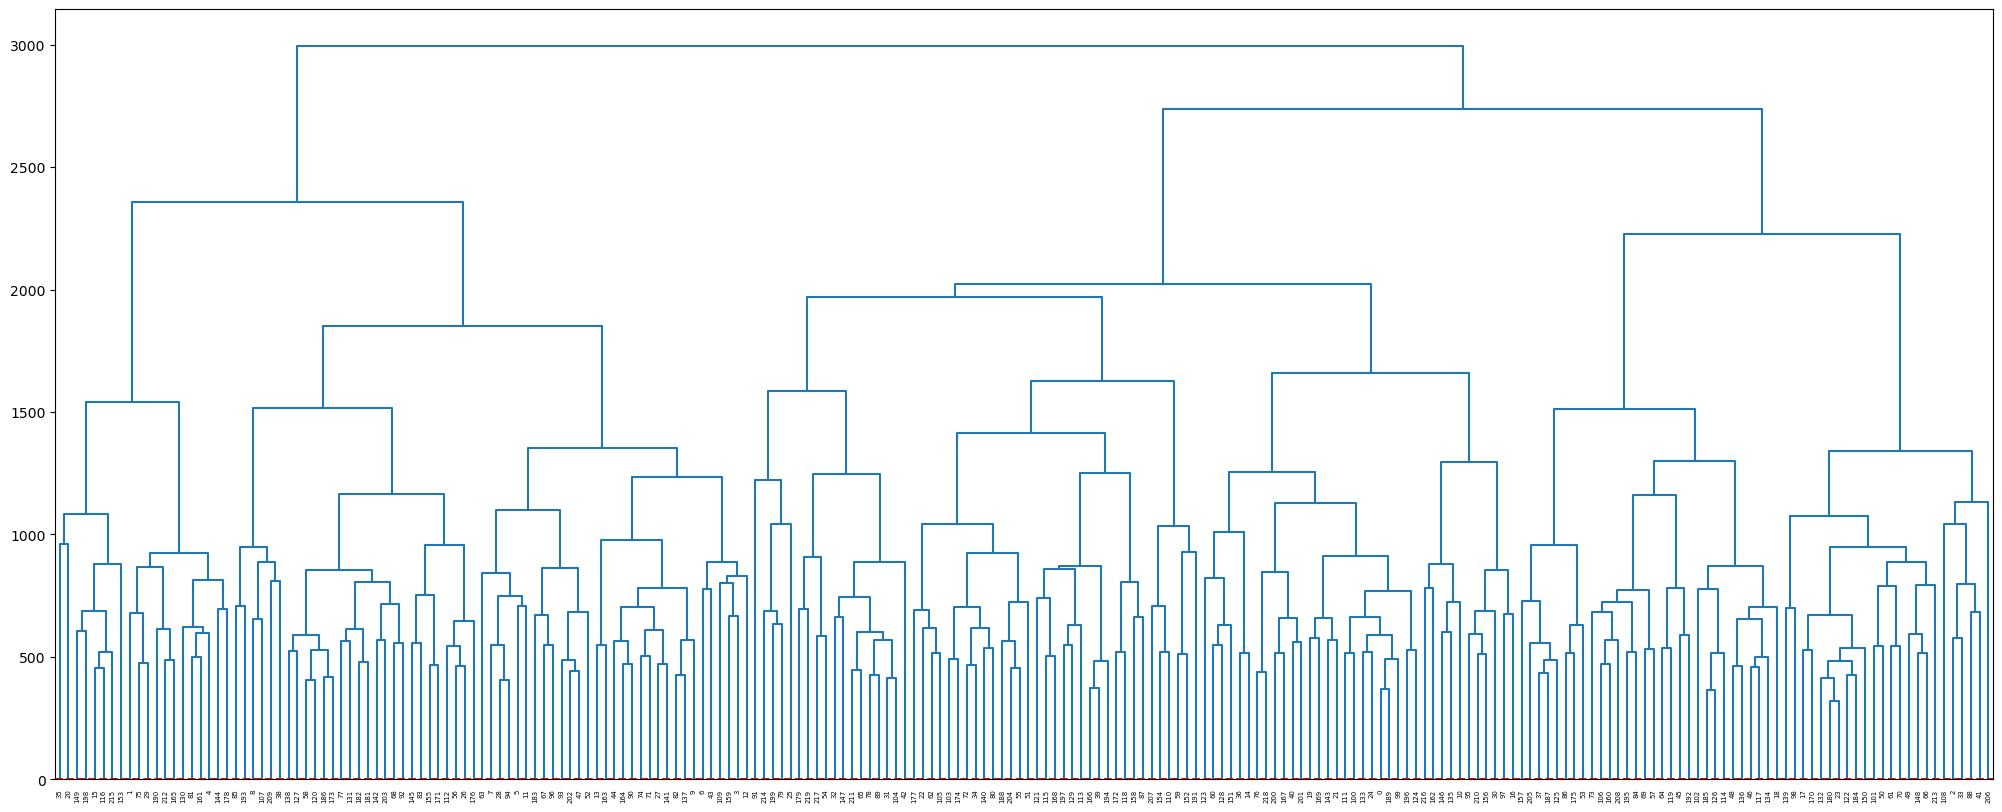

In [76]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = .8)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [77]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([ 35,  20, 149, 198,  15, 116, 215, 153,   1,  75,  29, 190, 212,
       165, 130,  81, 161,   4, 144, 178,  85, 193,   8, 107, 209,  38,
       138, 127,  58, 120, 186, 173,  77, 131, 182, 181, 142, 203,  68,
        92, 145,  83, 155, 171, 112,  56,  26, 176,  63,   7,  28,  94,
         5,  11, 183,  67,  96,  93, 202,  47,  52,  13, 163,  44, 164,
        90,  74,  71,  27, 141,  82, 137,   9,   6,  43, 109, 159,   3,
        12,  91, 214, 199,  79,  25, 179, 219, 217,  54,  32, 147, 211,
        65,  78,  89,  31, 104,  42, 177,  22,  62, 105, 103, 174,  72,
        34, 140,  80, 188, 204,  55,  51, 121, 115, 168, 197, 129, 113,
       166,  39, 194, 172, 118, 158,  87, 207, 154, 110,  59, 152, 191,
       123,  60, 128, 151,  36,  14,  76, 218, 200, 167,  40, 201,  19,
       169, 143,  21, 111, 100, 133,  24,   0, 189,  99, 196, 124, 216,
       162, 146, 135,  10,  95, 210, 156,  30,  97,  16, 157, 205,  37,
       187, 125,  86, 175,  53,  73, 106, 160, 208, 195,  84,  6

In [78]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'HDLBP', 'PIAS4', 'ADH1B', 'LOC100507531', 'FAM83A', 'NXF4', 'RNF125',
       'DARS', 'DNAI1', 'MBTPS1'],
      dtype='object', length=220)

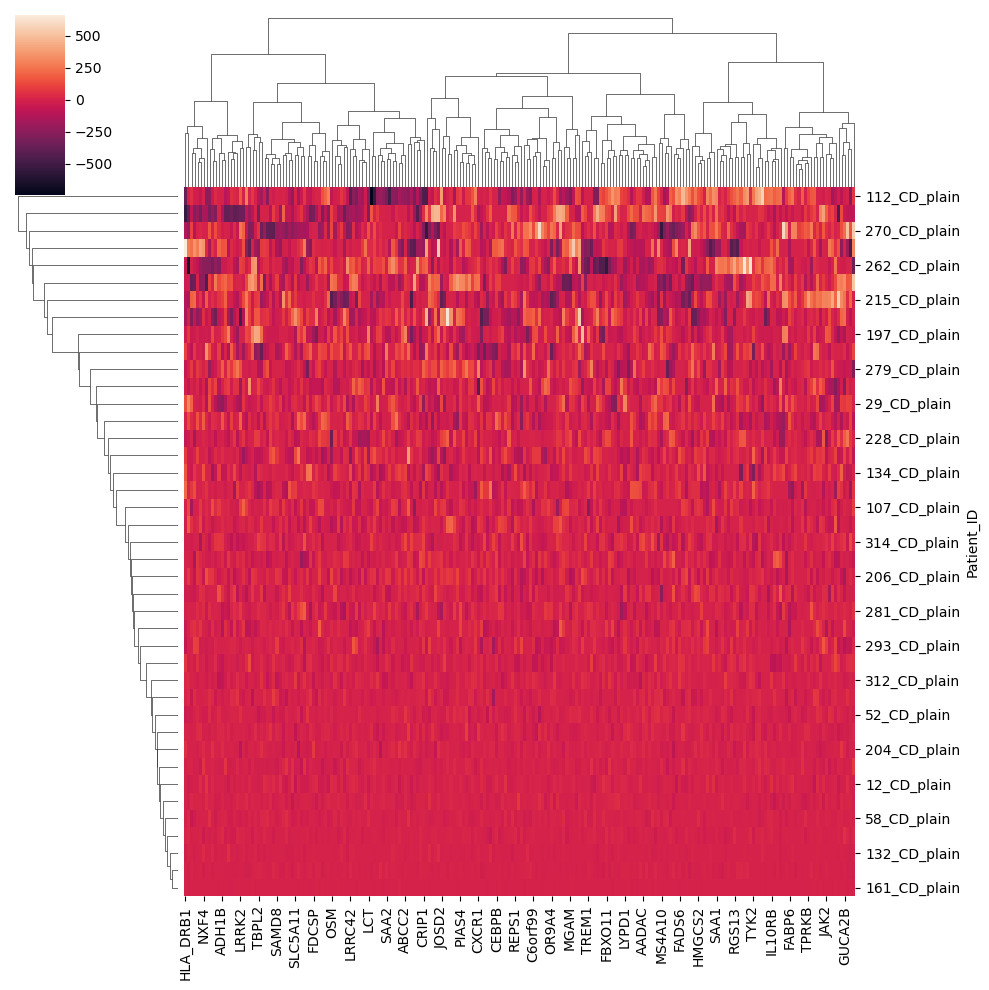

In [79]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing potential gene modules alongside SHAP contributions

In [80]:
gene_cluster_cd_plain

array([[1.80000000e+02, 2.30000000e+01, 3.20744124e+02, 2.00000000e+00],
       [1.85000000e+02, 1.26000000e+02, 3.64653336e+02, 2.00000000e+00],
       [0.00000000e+00, 1.89000000e+02, 3.68401850e+02, 2.00000000e+00],
       [1.66000000e+02, 3.90000000e+01, 3.74045033e+02, 2.00000000e+00],
       [2.80000000e+01, 9.40000000e+01, 4.05624893e+02, 2.00000000e+00],
       [5.80000000e+01, 1.20000000e+02, 4.06523322e+02, 2.00000000e+00],
       [1.32000000e+02, 2.20000000e+02, 4.13885521e+02, 3.00000000e+00],
       [3.10000000e+01, 1.04000000e+02, 4.15182117e+02, 2.00000000e+00],
       [1.86000000e+02, 1.73000000e+02, 4.16009949e+02, 2.00000000e+00],
       [1.22000000e+02, 1.84000000e+02, 4.24969925e+02, 2.00000000e+00],
       [8.20000000e+01, 1.37000000e+02, 4.26135888e+02, 2.00000000e+00],
       [7.80000000e+01, 8.90000000e+01, 4.27440589e+02, 2.00000000e+00],
       [3.70000000e+01, 1.87000000e+02, 4.33986808e+02, 2.00000000e+00],
       [7.60000000e+01, 2.18000000e+02, 4.36365469e

In [81]:
cluster_labels = fcluster(gene_cluster_cd_plain, .8, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(220,)

In [82]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([ 35,  20, 149, 198,  15, 116, 215, 153,  75,  29,   1, 212, 165,
        190,  81, 161,   4, 130, 144, 178,  85, 193,   8, 107, 209,  38,
        138, 127,  58, 120, 186, 173,  77, 131, 182, 181, 142, 203,  68,
         92, 145,  83, 155, 171,  56,  26, 112, 176,  28,  94,   7,   5,
         11,  63,  67,  96, 183, 202,  47,  93,  52,  13, 163, 164,  90,
         44,  74,  71,  27, 141,  82, 137,   9,   6,  43, 159,   3, 109,
         12, 199,  79, 214,  25,  91, 179, 219, 217,  54,  32, 147, 211,
         65,  78,  89,  31, 104,  42,  62, 105,  22, 177, 103, 174,  72,
         34, 140,  80, 204,  55, 188,  51, 115, 168, 121, 197, 129, 113,
        166,  39, 194, 172, 118, 158,  87, 154, 110, 207,  59, 152, 191,
         60, 128, 151, 123,  36,  14,  76, 218, 200, 167,  40, 201,  19,
        169, 143,  21, 111, 100, 133,  24,   0, 189,  99, 196, 124, 216,
        162, 146, 135,  10, 210, 156,  95,  30,  97,  16,  37, 187, 125,
        205, 157,  86, 175,  53, 106, 160, 208,  73

In [83]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [84]:
cluster_labels

array([151,  11, 215,  77,  17,  52,  74,  51,  23,  73, 160,  53,  79,
        62, 136,   5, 166, 199, 196, 143,   2, 146, 100, 202, 150,  83,
        46,  69,  49,  10, 164,  95,  89, 216, 105,   1, 135, 167,  26,
       119, 141, 218,  97,  75,  66, 185, 193,  59, 191, 213, 208, 111,
        61, 174,  88, 109,  45, 182,  29, 128, 131, 209,  98,  54, 183,
        92, 212,  55,  39, 181, 210,  68, 104, 178,  67,   9, 137,  33,
        93,  81, 107,  15,  71,  42, 180,  21, 172, 124, 217,  94,  65,
        84,  40,  60,  50, 163,  56, 165, 198, 153, 148, 207, 190, 102,
        96,  99, 175,  24, 219,  78, 126, 147,  47, 117, 189, 112,   6,
       194, 122, 184,  30, 114, 204, 134, 155, 169, 188,  28, 132, 116,
        18,  34, 203, 149, 195, 159, 192,  72,  27, 197, 106,  70,  37,
       145,  19,  41, 158,  90, 211,   3, 206, 133, 129,   8, 125,  43,
       162, 171, 123,  76, 176,  16, 157,  63,  64,  13, 118, 140, 113,
       144, 200,  44, 121,  32, 103, 173,  48, 101,  20,  85, 20

In [85]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,41.0,-0.031992,66.149735,-156.471330,-25.314122,0.000000,20.351665,251.158608,AADAC,151
APOA1,41.0,-16.489558,99.711270,-309.159855,-32.502400,-1.051642,3.298483,166.979570,APOA1,11
APOA4,41.0,19.227693,99.319448,-227.501723,-20.123073,0.000000,41.562554,324.588301,APOA4,215
APOB,41.0,-26.321778,93.530888,-287.093275,-34.534990,-7.020296,21.547949,130.197910,APOB,77
APOC3,41.0,-25.163734,93.058708,-374.927799,-44.089194,-4.542948,15.978007,257.356254,APOC3,17
...,...,...,...,...,...,...,...,...,...,...
NXF4,41.0,0.264828,95.063880,-258.026858,-18.451656,0.000000,23.352333,362.228077,NXF4,7
RNF125,41.0,-12.527956,114.208123,-287.210456,-27.804310,0.000000,28.124728,321.920772,RNF125,156
DARS,41.0,23.054136,111.338089,-96.142769,-11.752838,0.000000,5.879376,638.146205,DARS,87
DNAI1,41.0,-1.012579,108.180439,-444.134216,-8.465966,0.000000,31.658460,281.266819,DNAI1,138


In [86]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,-0.031992,151,AADAC
APOA1,-16.489558,11,APOA1
APOA4,19.227693,215,APOA4
APOB,-26.321778,77,APOB
APOC3,-25.163734,17,APOC3
...,...,...,...
NXF4,0.264828,7,NXF4
RNF125,-12.527956,156,RNF125
DARS,23.054136,87,DARS
DNAI1,-1.012579,138,DNAI1


In [87]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,-0.031992,151,AADAC
APOA1,-16.489558,11,APOA1
APOA4,19.227693,215,APOA4
APOB,-26.321778,77,APOB
APOC3,-25.163734,17,APOC3
...,...,...,...
NXF4,0.264828,7,NXF4
RNF125,-12.527956,156,RNF125
DARS,23.054136,87,DARS
DNAI1,-1.012579,138,DNAI1


In [88]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-6.980331,1,[HLA_DRB1]
2,-10.465738,1,[FCGR3A]
3,-6.052483,1,[SLC23A3]
4,-10.928861,1,[SDAD1P1]
5,9.556107,1,[CYP3A7]
...,...,...,...
216,17.993074,1,[GUCA2B]
217,12.678472,1,[STAT1]
218,-6.899129,1,[IL8]


In [89]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-6.980331,1,[HLA_DRB1],HLA_DRB1
2,-10.465738,1,[FCGR3A],FCGR3A
3,-6.052483,1,[SLC23A3],SLC23A3
4,-10.928861,1,[SDAD1P1],SDAD1P1
5,9.556107,1,[CYP3A7],CYP3A7
...,...,...,...,...
216,17.993074,1,[GUCA2B],GUCA2B
217,12.678472,1,[STAT1],STAT1
218,-6.899129,1,[IL8],IL8


In [90]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [91]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-6.980331,1,[HLA_DRB1],HLA_DRB1
2,-10.465738,1,[FCGR3A],FCGR3A
3,-6.052483,1,[SLC23A3],SLC23A3
4,-10.928861,1,[SDAD1P1],SDAD1P1
5,9.556107,1,[CYP3A7],CYP3A7
...,...,...,...,...
215,17.993074,1,[GUCA2B],GUCA2B
216,12.678472,1,[STAT1],STAT1
217,-6.899129,1,[IL8],IL8
218,-1.242115,1,[HCAR3],HCAR3


In [92]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-6.980331,1,[HLA_DRB1],HLA_DRB1
2,-10.465738,1,[FCGR3A],FCGR3A
3,-6.052483,1,[SLC23A3],SLC23A3
4,-10.928861,1,[SDAD1P1],SDAD1P1
5,9.556107,1,[CYP3A7],CYP3A7
...,...,...,...,...
216,12.678472,1,[STAT1],STAT1
217,-6.899129,1,[IL8],IL8
218,-1.242115,1,[HCAR3],HCAR3
219,19.227693,1,[APOA4],APOA4


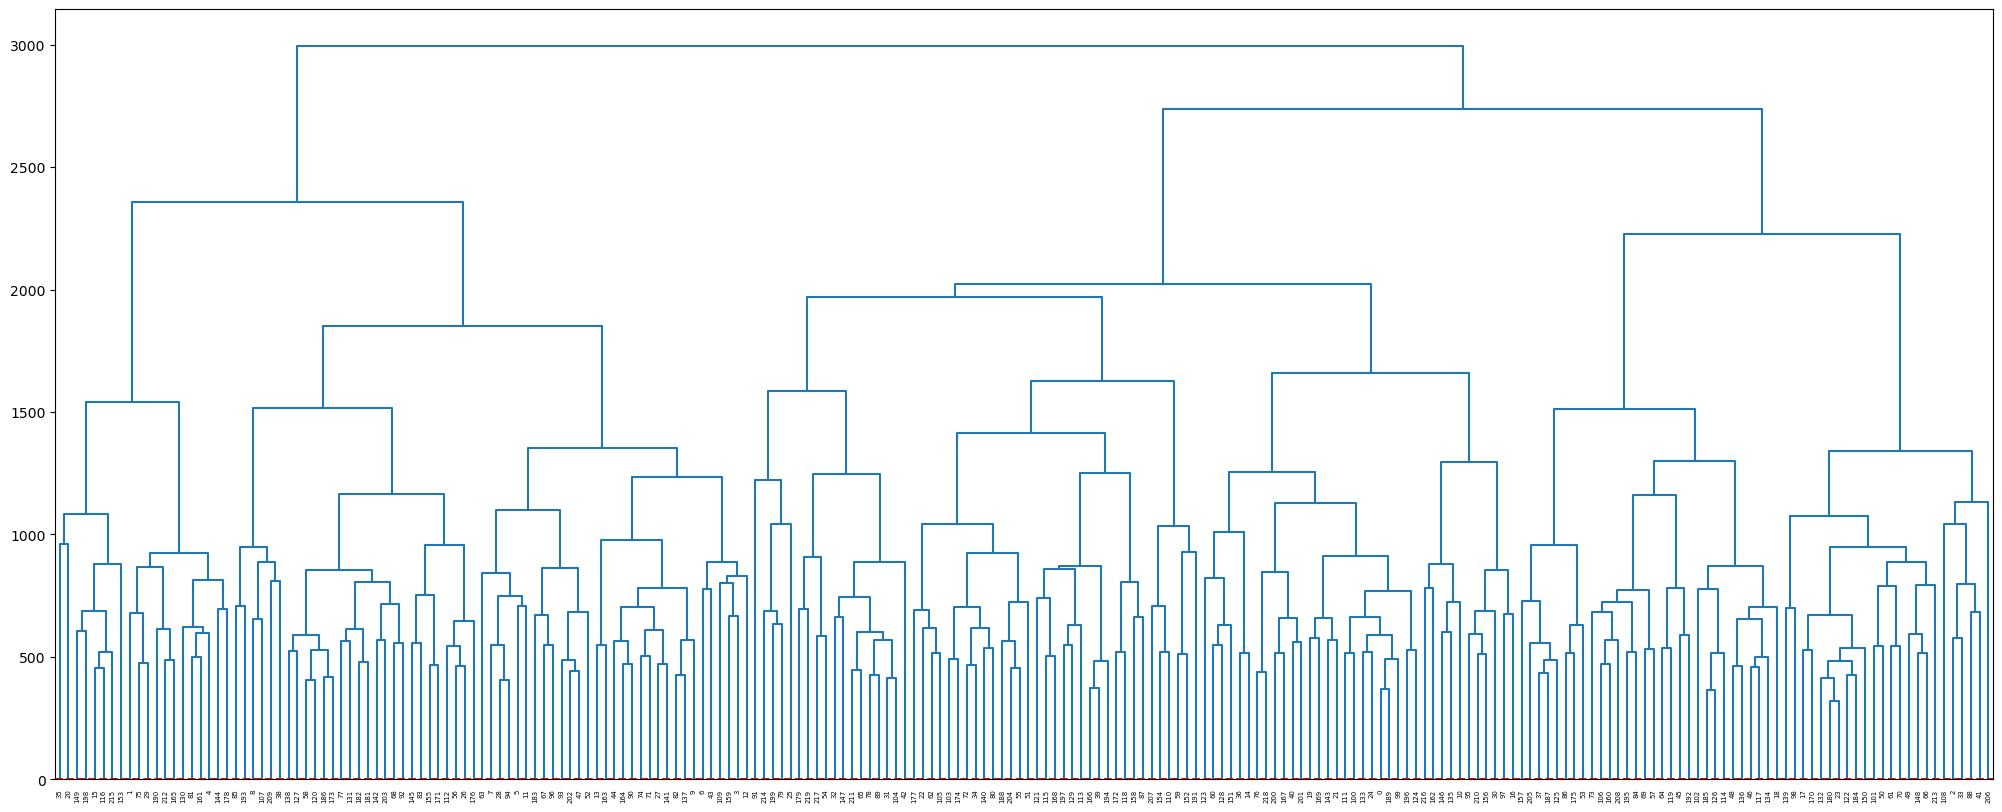

In [93]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

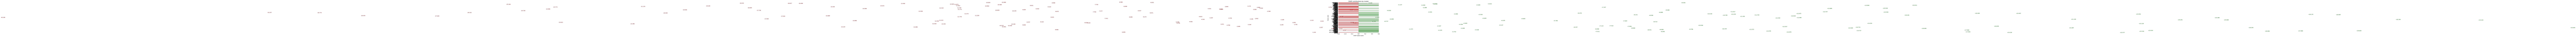

In [94]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [95]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")